# Bi2Se3 RHEED Patterns: Temperature-Dependent Recrystallization

This tutorial demonstrates kinematic RHEED simulation for Bi2Se3 structures
at different recrystallization temperatures. We observe how the diffraction
patterns evolve across the full Ewald sphere rotation (1-4 degrees).

## Structures
- **Initial**: Starting Bi2Se3 structure
- **500K**: Recrystallized at 500 K
- **750K**: Recrystallized at 750 K  
- **1000K**: Recrystallized at 1000 K
- **1250K**: Recrystallized at 1250 K

## Setup
- **Electron energy**: 30 keV
- **Grazing angles**: 1° to 4°
- **Zone axis**: [001] (viewing from z-axis)

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import rheedium as rh
import numpy as np
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2

## Load Crystal Structures

We use `parse_crystal` to directly read XYZ files. The function auto-detects
the file format and handles lattice information from extended XYZ metadata.

In [3]:
data_dir = Path("../tests/test_data/bi2se3")

# Load pristine Bi2Se3 from CIF file
pristine = rh.inout.parse_cif(data_dir / "Bi2Se3.cif")
print(f"Pristine: {pristine.cart_positions.shape[0]} atoms, "
      f"cell = [{pristine.cell_lengths[0]:.2f}, "
      f"{pristine.cell_lengths[1]:.2f}, "
      f"{pristine.cell_lengths[2]:.2f}] Å")

# Define structures with labels
structure_files = {
    "Initial": data_dir / "intial.xyz",
    "500K": data_dir / "500K.final.xyz",
    "750K": data_dir / "750K.final.xyz",
    "1000K": data_dir / "1000K.final.xyz",
    "1250K": data_dir / "1250K.final.xyz",
}

# Load all structures
crystals = {}
for label, filepath in structure_files.items():
    crystals[label] = rh.inout.parse_crystal(filepath)
    print(f"{label}: {crystals[label].cart_positions.shape[0]} atoms, "
          f"cell = [{crystals[label].cell_lengths[0]:.2f}, "
          f"{crystals[label].cell_lengths[1]:.2f}, "
          f"{crystals[label].cell_lengths[2]:.2f}] Å")

Pristine: 15 atoms, cell = [4.19, 4.19, 30.41] Å
Initial: 4000 atoms, cell = [72.49, 41.31, 100.00] Å
500K: 4000 atoms, cell = [73.52, 42.37, 100.00] Å
750K: 4000 atoms, cell = [74.28, 42.74, 100.00] Å
1000K: 4000 atoms, cell = [74.22, 42.84, 100.00] Å
1250K: 4000 atoms, cell = [74.27, 42.76, 100.00] Å


## Visualize Crystal Structures

First, let's view the atomic arrangements in the pristine unit cell and the 
recrystallized structures. The pristine Bi2Se3 has a rhombohedral structure
with quintuple layers (Se-Bi-Se-Bi-Se).

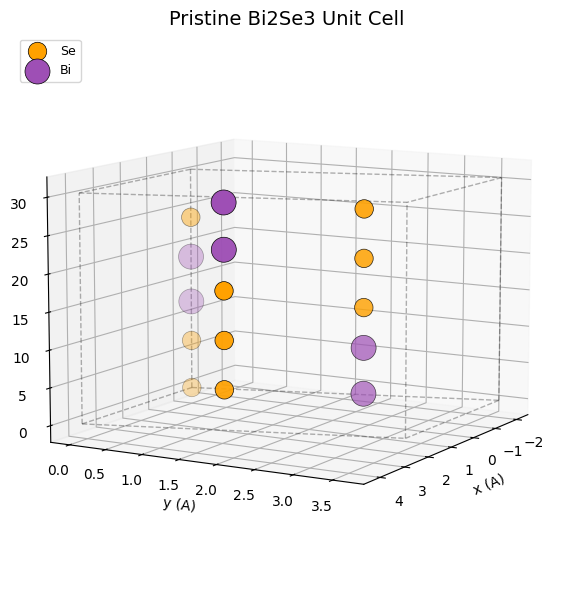

In [4]:
# View the pristine Bi2Se3 unit cell
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
rh.plots.view_atoms(pristine, elev=10, azim=30, atom_scale=1.5, ax=ax)
ax.set_title("Pristine Bi2Se3 Unit Cell", fontsize=14)
plt.tight_layout()
plt.show()

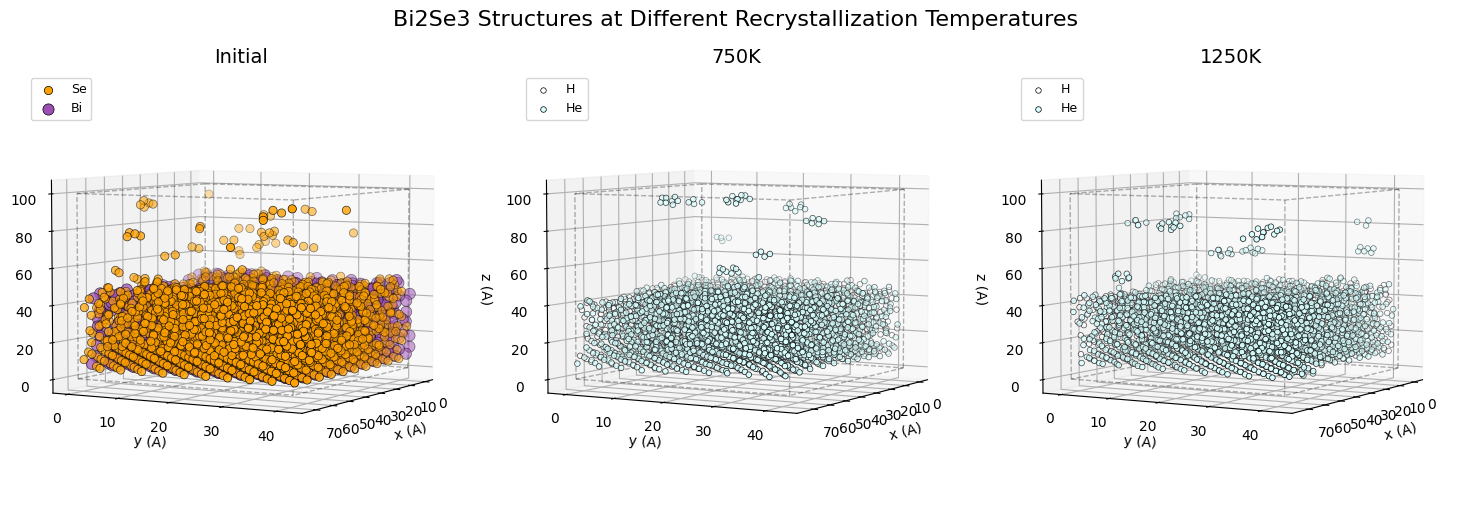

In [5]:
# Compare atomic structures at different recrystallization temperatures
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": "3d"})

# Select representative structures to compare
compare_labels = ["Initial", "750K", "1250K"]

for ax, label in zip(axes, compare_labels):
    rh.plots.view_atoms(crystals[label], elev=5, azim=30, atom_scale=0.3, ax=ax)
    ax.set_title(f"{label}", fontsize=14)

plt.suptitle("Bi2Se3 Structures at Different Recrystallization Temperatures", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Simulation Parameters

In [ ]:
# RHEED parameters
voltage_kV = 30.0
hmax, kmax = 3, 3
detector_distance = 80.0  # mm

# Grazing angles for Ewald sphere rotation
theta_range = [1.0, 2.0, 3.0, 4.0]  # degrees

# Electron wavelength and wavevector
wavelength = rh.simul.wavelength_ang(voltage_kV)
k_magnitude = 2 * jnp.pi / wavelength
print(f"Electron wavelength: {float(wavelength):.4f} Å")
print(f"Electron energy: {voltage_kV} keV")
print(f"Wavevector magnitude: {float(k_magnitude):.2f} Å⁻¹")

## RHEED Patterns at Different Grazing Angles

For each structure, we simulate the RHEED pattern at grazing angles from 1° to 4°.
This shows the full Ewald sphere rotation and how different reflections become active.

**Note on l-range**: These structures have a large unit cell (~100 Å along c-axis),
resulting in a small reciprocal lattice spacing (c* ≈ 0.063 Å⁻¹). To satisfy the
Ewald sphere condition (k_out_z > 0), we need l values around 50-150. We calculate
the appropriate range based on the crystal geometry.

In [ ]:
def compute_l_range(crystal, voltage_kv, theta_deg):
    """Compute appropriate l-range for Ewald sphere intersection.
    
    For large unit cells, the reciprocal lattice is dense and we need
    large l values to satisfy k_out_z > 0.
    """
    # Get c* magnitude
    c_length = crystal.cell_lengths[2]
    c_star = 2 * jnp.pi / c_length
    
    # Incident wavevector z-component (negative for grazing incidence)
    wavelength = rh.simul.wavelength_ang(voltage_kv)
    theta_rad = jnp.radians(theta_deg)
    k_in_z = -2 * jnp.pi / wavelength * jnp.sin(theta_rad)
    
    # Minimum l for k_out_z > 0: l * c* > -k_in_z
    l_min = float(-k_in_z / c_star) + 1.0  # Add margin
    l_max = l_min + 100.0  # Sample 100 l-units
    
    return l_min, l_max


def simulate_rheed_pattern(crystal, theta_deg, voltage_kv=30.0, hmax=3, kmax=3,
                           detector_distance=80.0):
    """Simulate kinematic CTR RHEED pattern with auto-computed l-range."""
    l_min, l_max = compute_l_range(crystal, voltage_kv, theta_deg)
    
    pattern = rh.simul.kinematic_ctr_simulator(
        crystal=crystal,
        voltage_kv=voltage_kv,
        theta_deg=theta_deg,
        hmax=hmax,
        kmax=kmax,
        detector_distance=detector_distance,
        l_min=l_min,
        l_max=l_max,
        n_points_per_rod=200,
    )
    return pattern


# Show l-range for initial structure at 2 degrees
example_crystal = crystals["Initial"]
l_min, l_max = compute_l_range(example_crystal, voltage_kV, 2.0)
print(f"For c = {float(example_crystal.cell_lengths[2]):.1f} Å at θ = 2°:")
print(f"  c* = {2 * jnp.pi / example_crystal.cell_lengths[2]:.4f} Å⁻¹")
print(f"  l-range: [{l_min:.1f}, {l_max:.1f}]")

In [ ]:
# Simulate patterns for all structures and angles
patterns = {}

for label, crystal in crystals.items():
    patterns[label] = {}
    for theta in theta_range:
        patterns[label][theta] = simulate_rheed_pattern(
            crystal, theta, voltage_kV, hmax, kmax, detector_distance
        )
    print(f"Simulated {label}: {len(theta_range)} angles")

## Visualization: Full Ewald Sphere Rotation

Each row shows a different structure (temperature), each column shows a different grazing angle.

In [ ]:
def render_pattern(pattern, grid_size=300, spot_width=0.03, x_range=(-1.0, 1.0), y_range=(0, 6)):
    """Render RHEED pattern to image array."""
    # Filter to valid points only
    valid = pattern.intensities > 0
    x_np = np.asarray(pattern.detector_points[valid, 0])
    y_np = np.asarray(pattern.detector_points[valid, 1])
    i_np = np.asarray(pattern.intensities[valid])
    
    x_axis = np.linspace(x_range[0], x_range[1], grid_size)
    y_axis = np.linspace(y_range[0], y_range[1], grid_size)
    xx, yy = np.meshgrid(x_axis, y_axis, indexing="xy")
    
    image = np.zeros_like(xx)
    for idx in range(len(i_np)):
        image += i_np[idx] * np.exp(
            -((xx - x_np[idx]) ** 2 + (yy - y_np[idx]) ** 2) / (2 * spot_width ** 2)
        )
    return image, x_axis, y_axis

In [ ]:
# Create comprehensive figure
structure_labels = list(crystals.keys())
n_structures = len(structure_labels)
n_angles = len(theta_range)

fig, axes = plt.subplots(n_structures, n_angles, figsize=(4 * n_angles, 4 * n_structures))

for i, label in enumerate(structure_labels):
    for j, theta in enumerate(theta_range):
        ax = axes[i, j]
        pattern = patterns[label][theta]
        image, x_axis, y_axis = render_pattern(pattern)
        
        ax.imshow(
            image,
            extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]],
            origin="lower",
            cmap="Greens",
            aspect="auto",
        )
        
        if i == 0:
            ax.set_title(f"θ = {theta}°", fontsize=14)
        if j == 0:
            ax.set_ylabel(f"{label}\ny_d (mm)", fontsize=12)
        else:
            ax.set_ylabel("")
        if i == n_structures - 1:
            ax.set_xlabel("x_d (mm)", fontsize=12)
        else:
            ax.set_xlabel("")

plt.suptitle("Bi2Se3 RHEED Patterns: Temperature-Dependent Recrystallization", 
             fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

## Single Structure Comparison: Ewald Sphere Rotation

Let's examine the initial structure in detail across all grazing angles.

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for j, theta in enumerate(theta_range):
    ax = axes[j]
    pattern = patterns["Initial"][theta]
    image, x_axis, y_axis = render_pattern(pattern, grid_size=400)
    
    ax.imshow(
        image,
        extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]],
        origin="lower",
        cmap="Greens",
        aspect="auto",
    )
    ax.set_title(f"θ = {theta}°", fontsize=14)
    ax.set_xlabel("x_d (mm)", fontsize=12)
    if j == 0:
        ax.set_ylabel("y_d (mm)", fontsize=12)

plt.suptitle("Initial Bi2Se3 Structure: Ewald Sphere Rotation", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Temperature Comparison at Fixed Angle

Compare all temperature conditions at a fixed grazing angle (2°).

In [ ]:
theta_fixed = 2.0

fig, axes = plt.subplots(1, n_structures, figsize=(4 * n_structures, 4))

for i, label in enumerate(structure_labels):
    ax = axes[i]
    pattern = patterns[label][theta_fixed]
    image, x_axis, y_axis = render_pattern(pattern, grid_size=400)
    
    ax.imshow(
        image,
        extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]],
        origin="lower",
        cmap="Greens",
        aspect="auto",
    )
    ax.set_title(f"{label}", fontsize=14)
    ax.set_xlabel("x_d (mm)", fontsize=12)
    if i == 0:
        ax.set_ylabel("y_d (mm)", fontsize=12)

plt.suptitle(f"Bi2Se3 Recrystallization at θ = {theta_fixed}°", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Summary Statistics

In [ ]:
print("Pattern Statistics (θ = 2.0°):")
print("=" * 60)
print(f"{'Structure':<12} {'Streak Points':<15} {'Unique Rods':<15} {'Max Intensity':<15}")
print("-" * 60)

for label in structure_labels:
    pattern = patterns[label][2.0]
    n_points = len(pattern.intensities)
    n_rods = len(jnp.unique(pattern.G_indices))
    max_i = float(jnp.max(pattern.intensities))
    print(f"{label:<12} {n_points:<15} {n_rods:<15} {max_i:<15.4f}")